In [1]:
from library import *
import time

In [2]:
from numpy.random import Generator, PCG64

In [3]:
result_dir = "results/find_env_on_real_qc/"

# first test it on simulation.

In [4]:
g0 = 1

In [5]:
U_param_values = np.genfromtxt(f"results/ground_state_params_3cnot_in_U__g={g0}_with_zz:1_3.csv")
mps = iMPS(create_V_gate("V", 1), create_U_gate("U", 1,1, reps=3), U_param_values)

In [6]:
def get_init_params(seed):
    np.random.seed(seed)
    return dict(zip(mps.V_param_n, 2*np.pi*np.random.random(len(mps.V_param_n))))


In [14]:
import matplotlib
cmap = matplotlib.colormaps['tab10']
import matplotlib.lines as mlines

def plot(file_name, titles, save=False, estimated=False):
    colors = ["green", "red", "blue", "orange", "magenta", "cyan", "yellow", "brown", "gray", "black"]
    fig_trace, ax_trace = plt.subplots()
    fig_V_params, ax_V_params = plt.subplots()
    for seed in range(0,10):
        result_file = result_dir + file_name.format(seed) + ".csv"
        result = np.genfromtxt(result_file, skip_header=True, delimiter=",")
        x = np.arange(result.shape[0])/len(mps.V_param_n)
        ax_trace.semilogy(x, result[:,0], alpha=.8, color=cmap(seed/10))
        
        params_list = [join_params(dict(zip(mps.V_param_n, params)), mps.U_params) for params in result[:,1:]]
        if estimated:
            ax_trace.scatter(x, estimate_trace_of_difference(mps.U, mps.V, params_list), color=cmap(seed/10), marker="x")
        #print(result[:,0])
        for i in range(1,4):
            ax_V_params.plot(x, result[:,i], color=colors[i-1], alpha = .2, label=str(mps.V_param_n[i-1]) if seed==0 else None)
    
    ax_V_params.legend()
    ax_V_params.set_title(f"{titles}")
    ax_V_params.set_ylabel("Parameters of environment $\\hat V$")
    ax_V_params.set_xlabel("Iteration")
    ax_trace.set_title(f"{titles}")
    ax_trace.set_ylabel("$\\mathrm{Tr}((ρ-σ)^\\dagger (ρ-σ)) = \\mathrm{Tr}(ρρ)-2\\mathrm{Tr}(ρσ)+\\mathrm{Tr}(σσ)$")
    ax_trace.set_xlabel("Iteration")

    # Create custom legend entries
    if estimated:
        data_line = mlines.Line2D([], [], color='gray', label='estimation used in optimization')
        marker = mlines.Line2D([], [], color='gray', marker='x', linestyle='None', label='exact trace')
        # Add a legend with the custom legend entries
        ax_trace.legend(handles=[data_line, marker])
    else:
        data_line = mlines.Line2D([], [], color='gray', label='exact trace used in optimization')
        # Add a legend with the custom legend entries
        ax_trace.legend(handles=[data_line])
    
    
    if save:
        fig_trace.savefig(result_dir + file_name.format("...") + "_trace.pdf")
        fig_V_params.savefig(result_dir + file_name.format("...") + "_V_params.pdf")


In [9]:
switch_settings_to_simulation()

for seed in range(10):
    result_file = result_dir+f"rotosolve_optimization_simulating_exactly_{seed}.csv"
    V_init_params = get_init_params(seed)
    V_params = find_environment_V(mps.U, mps.V, V_init_params.copy(), other_parameters = mps.U_params, quiet=True, log_file=result_file, may_overwrite=True)
    print(V_params)
    # this should be 0 if the optimization worked well.
    print(estimate_trace_of_difference_classically(mps.U, mps.V, join_params(V_params, mps.U_params)))

/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


{Parameter($v^0_1$): 3.941017206725816, Parameter($v^0_2$): 0.8090219864263739, Parameter($v^0_p$): 5.581015686986538}
5.1229944357786467e-11
{Parameter($v^0_1$): 2.3421609623791775, Parameter($v^0_2$): 3.950611297089958, Parameter($v^0_p$): 5.581015410170442}
1.6516538160057875e-11
{Parameter($v^0_1$): 2.342163508981659, Parameter($v^0_2$): 3.9506167415859847, Parameter($v^0_p$): 5.581015858716022}
1.1266192542208583e-11
{Parameter($v^0_1$): 3.941017934664903, Parameter($v^0_2$): 0.809022319612847, Parameter($v^0_p$): 5.581015714330958}
4.2965960242034025e-11
{Parameter($v^0_1$): 5.4837549339589895, Parameter($v^0_2$): 3.9506049156966245, Parameter($v^0_p$): 2.439422215719565}
5.801671416778238e-11
{Parameter($v^0_1$): 0.7994292817615749, Parameter($v^0_2$): 0.8090241507744369, Parameter($v^0_p$): 3.843762096363961}
1.051634619752844e-11
{Parameter($v^0_1$): 5.483754879843791, Parameter($v^0_2$): 3.950605177708654, Parameter($v^0_p$): 2.4394222382480075}
5.581594848309294e-11
{Paramet

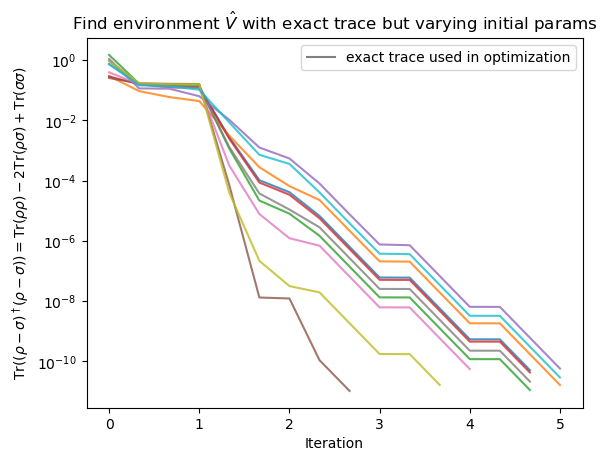

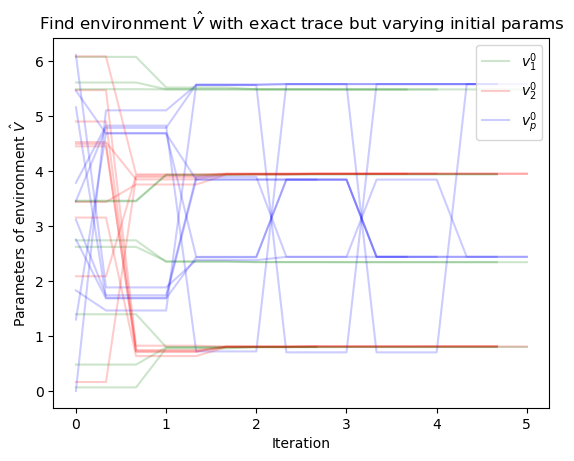

In [15]:
file_name = "rotosolve_optimization_simulating_exactly_{0}"
plot(file_name, "Find environment $\\hat V$ with exact trace but varying initial params", save=True)

# simulate with limited shot number

In [72]:
for desired_minimum in [0,-1]:
    # if desired minimum = -1 the optimization won't stop so easily and we can see, that the accuracy stays at shots^(-1/2)
    # (it might not always reach max iter because the optimization also stops if the parameters stay almost constant, which is very improbable given the noise
    for shots in [100, 10000, 1000000]:
        file_name = f"rotosolve-optimization_limited-shot-number:_{shots}__init-seed:_{{0}}" + ("" if desired_minimum==0 else "__max_iter")
        
        for seed in range(10):
            set_estimator_options({"seed": Generator(PCG64(42+seed)), "shots": shots})
            result_file = result_dir + file_name.format(seed) + ".csv"
            V_init_params = get_init_params(seed)
            V_params = find_environment_V(mps.U, mps.V, V_init_params.copy(), other_parameters = mps.U_params, desired_minimum=desired_minimum, quiet=True, tolerance=.0001, log_file=result_file, may_overwrite=True)
            print(V_params)
            # this should be 0 if the optimization worked well.
            estimate_trace_of_difference_classically(mps.U, mps.V, join_params(V_params, mps.U_params))

bad accuracy. new func value: [0.23253866], previous was [0.06265418]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 4.012106983250123, Parameter($v^0_2$): 0.9821850606547495, Parameter($v^0_p$): 5.1847509726174}
{Parameter($v^0_1$): 2.620226532717789, Parameter($v^0_2$): 4.525932273597346, Parameter($v^0_p$): 5.430727940922077}


bad accuracy. new func value: [0.7119291], previous was [0.05322139]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.32431205], previous was [0.29064277]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.66967162], previous was [0.32431205]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.44017204], previous was [0.24734664]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 2.7394367631438397, Parameter($v^0_2$): 4.586690783360533, Parameter($v^0_p$): 4.762844213480802}


bad accuracy. new func value: [0.27384359], previous was [0.04847087]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35269752], previous was [0.27384359]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.4088177], previous was [0.30862502]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.39559569], previous was [0.06293428]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10022313], previous was [0.00192052]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoid

{Parameter($v^0_1$): 2.540638588924902, Parameter($v^0_2$): 2.8999376669745875, Parameter($v^0_p$): 1.0454595745197737}


bad accuracy. new func value: [0.30211775], previous was [0.17199818]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.3469155], previous was [0.30211775]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.57030264], previous was [0.17215164]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.742425783020499, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 2.3819358523169836}


bad accuracy. new func value: [0.45645948], previous was [0.12349425]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.18590248], previous was [0.1035467]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 1.3948242308852552, Parameter($v^0_2$): 3.4937001901172335, Parameter($v^0_p$): 4.845318893571742}


bad accuracy. new func value: [0.07634491], previous was [0.00442258]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.26530531], previous was [0.03642475]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.31767544], previous was [0.04248982]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.370803520823112, Parameter($v^0_2$): 4.003631295379902, Parameter($v^0_p$): 4.041367991063271}


bad accuracy. new func value: [0.24553449], previous was [0.1662974]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.19841021], previous was [0.02685946]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.64191975], previous was [0.19841021]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.427663370536052, Parameter($v^0_2$): 4.900374296196336, Parameter($v^0_p$): 4.688891299406904}
{Parameter($v^0_1$): 5.4879187904801805, Parameter($v^0_2$): 6.0855204620424574, Parameter($v^0_p$): 1.759387995667572}
{Parameter($v^0_1$): 0.06518273126904997, Parameter($v^0_2$): 3.153371063435703, Parameter($v^0_p$): 1.9232478707953284}
{Parameter($v^0_1$): 3.9757643351980203, Parameter($v^0_2$): 0.8474366796339274, Parameter($v^0_p$): 0.8187632576733397}
{Parameter($v^0_1$): 2.317683271181477, Parameter($v^0_2$): 4.01288759955764, Parameter($v^0_p$): 0.7490092065862273}


bad accuracy. new func value: [0.19596004], previous was [0.1334019]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02201558], previous was [0.00716416]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 2.391407175073989, Parameter($v^0_2$): 3.999099910248826, Parameter($v^0_p$): 5.528156055594508}


bad accuracy. new func value: [0.15842657], previous was [0.14891044]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0168305], previous was [0.00557903]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01731057], previous was [0.0168305]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 2.347572994066874, Parameter($v^0_2$): 4.00319224890734, Parameter($v^0_p$): 5.5518051282226875}
{Parameter($v^0_1$): 5.45464048121795, Parameter($v^0_2$): 3.9515578315482474, Parameter($v^0_p$): 2.5151486285808553}


bad accuracy. new func value: [0.1682627], previous was [0.16736685]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.19201032], previous was [0.1682627]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.17398289], previous was [0.16108062]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.12707921], previous was [0.0948703]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.07525578], previous was [0.07208611]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal

{Parameter($v^0_1$): 0.7464000979493299, Parameter($v^0_2$): 0.8872385859035377, Parameter($v^0_p$): 2.195067909114824}
{Parameter($v^0_1$): 5.465129644446857, Parameter($v^0_2$): 3.9035227326949156, Parameter($v^0_p$): 3.837873532826631}


bad accuracy. new func value: [0.11753018], previous was [0.11541576]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.15368491], previous was [0.11753018]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.16252926], previous was [0.15368491]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10507084], previous was [0.09453995]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11145231], previous was [0.10115262]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 0.7231928503064813, Parameter($v^0_2$): 0.6518762247833405, Parameter($v^0_p$): 2.164949172517872}


bad accuracy. new func value: [0.22381972], previous was [0.12809334]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.16881083], previous was [0.15845081]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20164567], previous was [0.16881083]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20395256], previous was [0.20164567]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20651789], previous was [0.20395256]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 3.9636283173451443, Parameter($v^0_2$): 0.8418600338665354, Parameter($v^0_p$): 0.9657853834078369}


bad accuracy. new func value: [0.15600202], previous was [0.11532131]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11524147], previous was [0.10853528]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10025516], previous was [0.09330424]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0072216], previous was [0.00069244]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01549308], previous was [0.0072216]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoida

{Parameter($v^0_1$): 5.483360478914692, Parameter($v^0_2$): 3.9379759066876643, Parameter($v^0_p$): 2.4992957685576096}
{Parameter($v^0_1$): 3.9416407621608487, Parameter($v^0_2$): 0.8116754840970897, Parameter($v^0_p$): 0.7023449281865446}


bad accuracy. new func value: [0.00252137], previous was [0.00070104]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 2.360036951890074, Parameter($v^0_2$): 3.868463761695806, Parameter($v^0_p$): 0.718865684213231}


bad accuracy. new func value: [0.14593026], previous was [0.14275756]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00230687], previous was [0.00131508]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 2.374137101059774, Parameter($v^0_2$): 3.942886884356162, Parameter($v^0_p$): 5.572650941886591}
{Parameter($v^0_1$): 3.942210563863163, Parameter($v^0_2$): 0.810988825118323, Parameter($v^0_p$): 5.574959243680513}
{Parameter($v^0_1$): 5.4879198012155666, Parameter($v^0_2$): 3.9394091842816907, Parameter($v^0_p$): 2.4195886489185177}


bad accuracy. new func value: [0.16607016], previous was [0.16469404]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 0.8020440004507177, Parameter($v^0_2$): 0.8227540718761492, Parameter($v^0_p$): 2.360174938003875}
{Parameter($v^0_1$): 5.509622163597559, Parameter($v^0_2$): 3.939591476965489, Parameter($v^0_p$): 2.3999489518329917}
{Parameter($v^0_1$): 0.7983524398837836, Parameter($v^0_2$): 0.7992625983145993, Parameter($v^0_p$): 3.8510552989515947}


bad accuracy. new func value: [0.02333385], previous was [0.02261938]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.476843515669179, Parameter($v^0_2$): 3.9528796167807867, Parameter($v^0_p$): 2.439708190464243}
{Parameter($v^0_1$): 0.8059252423336871, Parameter($v^0_2$): 0.8123700897681378, Parameter($v^0_p$): 3.8621682070614636}


bad accuracy. new func value: [0.23253866], previous was [0.06265418]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.2094463], previous was [-0.0698187]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11150556], previous was [0.05123525]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01998803], previous was [-0.23321534]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02723695], previous was [0.01998803]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 1.680574652565372, Parameter($v^0_2$): 5.54201255129287, Parameter($v^0_p$): 1.7096646813759806}


bad accuracy. new func value: [-0.01781244], previous was [-0.07430648]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.06785274], previous was [-0.01781244]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.36157883], previous was [-0.07951248]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20905889], previous was [-0.25695044]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.5963969], previous was [-0.06556671]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 3.7714561084778597, Parameter($v^0_2$): 0.9145868281798233, Parameter($v^0_p$): 0.6583403244454753}


bad accuracy. new func value: [0.7119291], previous was [0.05322139]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.32431205], previous was [0.29064277]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.66967162], previous was [0.32431205]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.44017204], previous was [0.24734664]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.16037344], previous was [-0.09881741]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.350890035245768, Parameter($v^0_2$): 4.022713950633453, Parameter($v^0_p$): 3.917021229302443}


bad accuracy. new func value: [0.27384359], previous was [0.04847087]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35269752], previous was [0.27384359]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.4088177], previous was [0.30862502]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.39559569], previous was [0.06293428]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10022313], previous was [0.00192052]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoid

{Parameter($v^0_1$): 5.187547691026046, Parameter($v^0_2$): 4.256645454286933, Parameter($v^0_p$): 4.507699938201359}


bad accuracy. new func value: [0.57030264], previous was [0.17215164]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11490808], previous was [-0.02393536]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20187025], previous was [0.11490808]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.21111309], previous was [-0.15463488]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.1369097], previous was [-0.18195423]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 4.669588955101533, Parameter($v^0_2$): 4.0566108204822555, Parameter($v^0_p$): 2.076915431409722}


bad accuracy. new func value: [0.18590248], previous was [0.1035467]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.30032801], previous was [-0.23995698]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.02797694], previous was [-0.07612033]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.01738526], previous was [-0.02797694]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11283097], previous was [-0.01738526]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 5.2706694071665545, Parameter($v^0_2$): 4.220650064614965, Parameter($v^0_p$): 2.0394361546169746}


bad accuracy. new func value: [0.07634491], previous was [0.00442258]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.26530531], previous was [0.03642475]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.31767544], previous was [0.04248982]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10088168], previous was [-0.1352536]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.37614306], previous was [-0.09395453]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinuso

{Parameter($v^0_1$): 3.031977352834081, Parameter($v^0_2$): 2.137176012256833, Parameter($v^0_p$): 4.804898260009134}


bad accuracy. new func value: [0.19841021], previous was [0.02685946]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.64191975], previous was [0.19841021]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.49984315], previous was [-0.05427417]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.14269091], previous was [0.02630234]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.16119881], previous was [0.05286421]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinuso

{Parameter($v^0_1$): 6.04094352616384, Parameter($v^0_2$): 3.719241407680563, Parameter($v^0_p$): 4.353696333618514}


bad accuracy. new func value: [0.2082653], previous was [0.1921327]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.28040945], previous was [0.2082653]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.55544054], previous was [0.28040945]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.405993], previous was [0.34329552]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.09307957], previous was [-0.28986757]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal 

{Parameter($v^0_1$): 3.8456559159662627, Parameter($v^0_2$): 0.6213886282043921, Parameter($v^0_p$): 5.311152480270998}


bad accuracy. new func value: [0.46937417], previous was [0.30361807]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.46266266], previous was [0.23453694]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.25949072], previous was [0.2277947]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.07386392], previous was [-0.07810045]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.13065624], previous was [0.07386392]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 1.9134488943833163, Parameter($v^0_2$): 4.271226050828201, Parameter($v^0_p$): 1.025298944626714}


bad accuracy. new func value: [0.01373824], previous was [-0.01784284]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01571354], previous was [0.00718542]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00119996], previous was [-0.02145059]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0062275], previous was [-0.01895647]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01093638], previous was [0.00515014]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 3.9450067603042305, Parameter($v^0_2$): 0.8069864941264155, Parameter($v^0_p$): 0.6847012152598775}


bad accuracy. new func value: [0.02489491], previous was [-0.01201005]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00594613], previous was [-0.03506409]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01369435], previous was [-0.02216941]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01294629], previous was [-0.0096063]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0118792], previous was [-0.00466123]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 2.335819736145461, Parameter($v^0_2$): 3.9714852638050697, Parameter($v^0_p$): 0.7788047051348044}


bad accuracy. new func value: [0.19596004], previous was [0.1334019]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02201558], previous was [0.00716416]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00312246], previous was [-0.01509724]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00160075], previous was [-0.02451154]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.04329917], previous was [0.00160075]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinuso

{Parameter($v^0_1$): 2.3494008836139577, Parameter($v^0_2$): 3.9472035059879538, Parameter($v^0_p$): 0.5735246769669446}


bad accuracy. new func value: [0.0168305], previous was [0.00557903]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01731057], previous was [0.0168305]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01328851], previous was [-0.00886572]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01042954], previous was [-0.01353816]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00640631], previous was [-0.01357692]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 2.295960852441872, Parameter($v^0_2$): 3.965048126508965, Parameter($v^0_p$): 0.7739412514668884}


bad accuracy. new func value: [0.02184451], previous was [-0.00313065]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00383107], previous was [-0.00758082]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00740396], previous was [0.00383107]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01268813], previous was [-0.02033815]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01103863], previous was [-0.0169229]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 5.449877840132402, Parameter($v^0_2$): 3.9459113396661922, Parameter($v^0_p$): 2.3240524397635}


bad accuracy. new func value: [0.1682627], previous was [0.16736685]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.19201032], previous was [0.1682627]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.17398289], previous was [0.16108062]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.12707921], previous was [0.0948703]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.07525578], previous was [0.07208611]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal

{Parameter($v^0_1$): 0.8141182080650675, Parameter($v^0_2$): 0.7985899463957575, Parameter($v^0_p$): 2.3586690715722973}


bad accuracy. new func value: [0.00430586], previous was [-0.002177]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00932484], previous was [-0.01270979]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0001072], previous was [-0.00906367]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0007707], previous was [0.0001072]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01543573], previous was [-0.0232387]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoida

{Parameter($v^0_1$): 5.492571472352007, Parameter($v^0_2$): 3.970508233552502, Parameter($v^0_p$): 3.676228133473148}


bad accuracy. new func value: [0.11753018], previous was [0.11541576]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.15368491], previous was [0.11753018]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.16252926], previous was [0.15368491]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10507084], previous was [0.09453995]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11145231], previous was [0.10115262]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 0.8203579537964281, Parameter($v^0_2$): 0.742124738864518, Parameter($v^0_p$): 3.874941613384993}


bad accuracy. new func value: [0.16881083], previous was [0.15845081]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20164567], previous was [0.16881083]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20395256], previous was [0.20164567]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20651789], previous was [0.20395256]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.07877452], previous was [0.07653542]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 3.934144892661024, Parameter($v^0_2$): 0.7921333300736211, Parameter($v^0_p$): 5.500383880288816}


bad accuracy. new func value: [0.11524147], previous was [0.10853528]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.10025516], previous was [0.09330424]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0072216], previous was [0.00069244]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01549308], previous was [0.0072216]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00714636], previous was [-0.01008539]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.4997777903927165, Parameter($v^0_2$): 3.9637732538147175, Parameter($v^0_p$): 3.899148291281418}


bad accuracy. new func value: [0.00129682], previous was [-0.00195214]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00121189], previous was [0.0004503]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [2.38734153e-05], previous was [-0.00219258]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00042221], previous was [-0.00209221]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00073278], previous was [0.00021418]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly s

{Parameter($v^0_1$): 3.9414234999752535, Parameter($v^0_2$): 0.8087803552775448, Parameter($v^0_p$): 0.700263503260854}


bad accuracy. new func value: [0.00252137], previous was [0.00070104]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00246865], previous was [-0.00158837]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00136801], previous was [-0.0019766]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00149877], previous was [-0.00076048]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0010551], previous was [-0.0004416]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinuso

{Parameter($v^0_1$): 2.341598946072364, Parameter($v^0_2$): 3.952467304122759, Parameter($v^0_p$): 0.7121513569881546}


bad accuracy. new func value: [0.14593026], previous was [0.14275756]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00230687], previous was [0.00131508]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [8.20861939e-05], previous was [-0.00107748]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0005807], previous was [-0.00200909]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00397667], previous was [0.0005807]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sin

{Parameter($v^0_1$): 2.342914723736521, Parameter($v^0_2$): 3.9504816333338058, Parameter($v^0_p$): 0.6875205368626824}


bad accuracy. new func value: [0.00147518], previous was [-0.00097221]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00030157], previous was [-0.00107797]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00124242], previous was [-0.00091364]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00103336], previous was [-0.00137651]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00068697], previous was [-0.00140636]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly 

{Parameter($v^0_1$): 3.945265707699174, Parameter($v^0_2$): 0.8075813821212017, Parameter($v^0_p$): 0.712248377808693}


bad accuracy. new func value: [0.00040824], previous was [-0.00081277]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00067498], previous was [0.00040824]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00129778], previous was [-0.00217697]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00116654], previous was [-0.00186986]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00117962], previous was [0.00102208]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 5.481131763824351, Parameter($v^0_2$): 3.950141158646615, Parameter($v^0_p$): 2.4237579349239367}


bad accuracy. new func value: [0.16607016], previous was [0.16469404]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.0003057], previous was [-0.00170085]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0005879], previous was [-0.00276565]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00207582], previous was [0.0005879]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00117271], previous was [-0.00398382]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 0.8006995299153874, Parameter($v^0_2$): 0.8082045892929424, Parameter($v^0_p$): 2.431007370278143}


bad accuracy. new func value: [0.00036388], previous was [-0.00012542]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00086394], previous was [0.0001047]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00087061], previous was [-0.00131401]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-7.43358352e-05], previous was [-0.0009416]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [5.25049528e-06], previous was [-7.43358352e-05]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is

{Parameter($v^0_1$): 5.484583218432146, Parameter($v^0_2$): 3.9519505640359434, Parameter($v^0_p$): 3.8293049628238176}


bad accuracy. new func value: [0.00236937], previous was [-0.00148117]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00026625], previous was [-0.00089886]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.0002074], previous was [-0.00079321]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0012171], previous was [-0.00054729]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00217859], previous was [-0.00238518]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 0.8018312305129642, Parameter($v^0_2$): 0.8024379746503651, Parameter($v^0_p$): 3.847874828712757}


bad accuracy. new func value: [0.02333385], previous was [0.02261938]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00104282], previous was [-0.00154165]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00084906], previous was [-0.00324141]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00041766], previous was [-0.00084906]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00070811], previous was [-0.00041766]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly 

{Parameter($v^0_1$): 5.48432261791436, Parameter($v^0_2$): 3.953345989106157, Parameter($v^0_p$): 2.423208896337032}


bad accuracy. new func value: [5.59279297e-05], previous was [-0.0008034]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0007392], previous was [5.59279297e-05]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00160202], previous was [0.0007392]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00072861], previous was [-0.00109475]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00281972], previous was [-0.00072861]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubl

{Parameter($v^0_1$): 0.7991159199014817, Parameter($v^0_2$): 0.813564140754631, Parameter($v^0_p$): 3.8512445532400363}


reached max iter: 25.
========warning: desired_minimum: -1 not reached, fun is at -0.0019176329214738441.


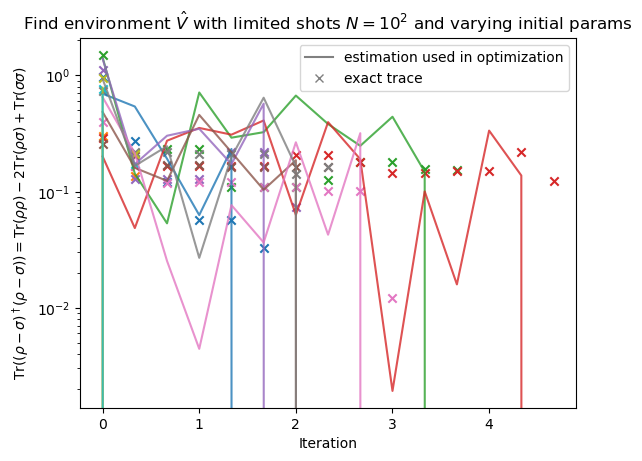

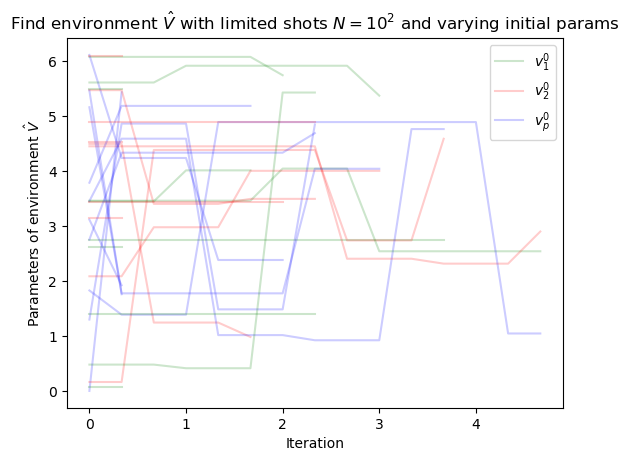

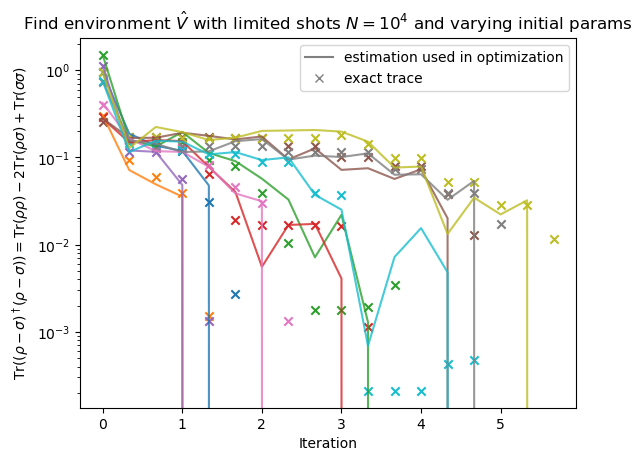

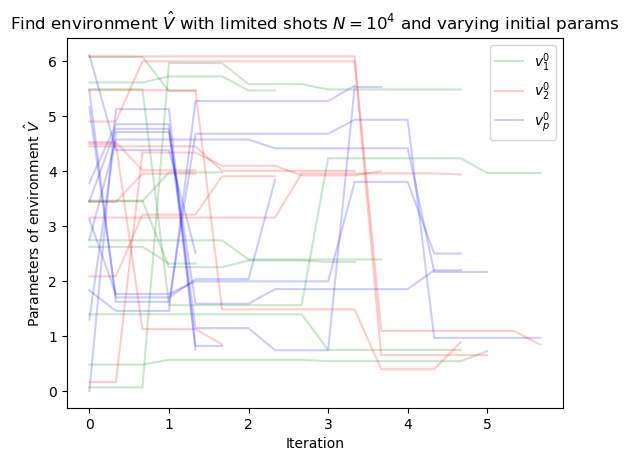

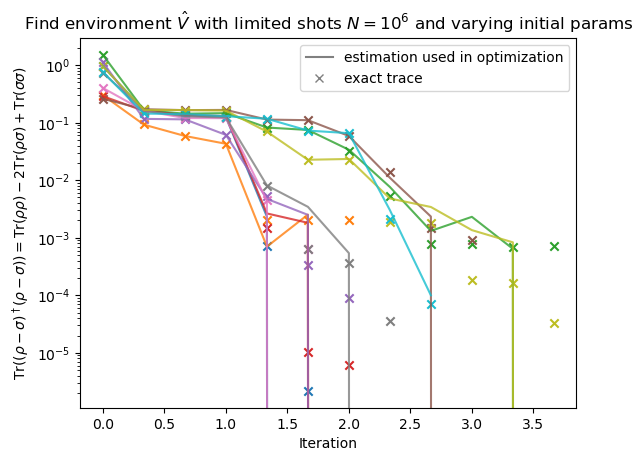

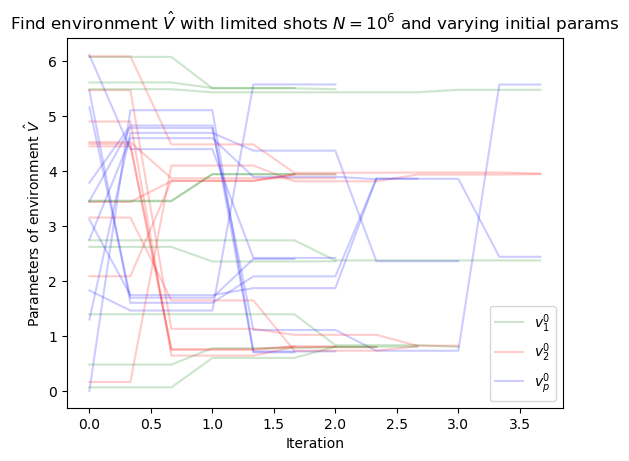

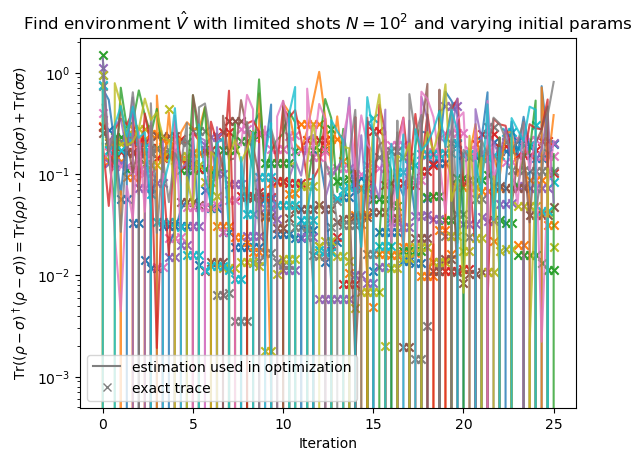

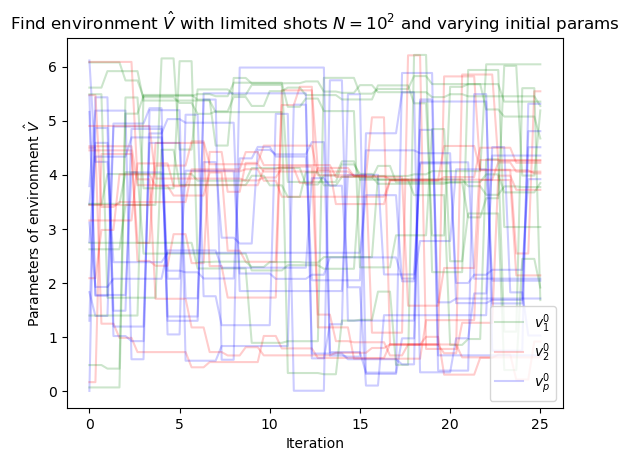

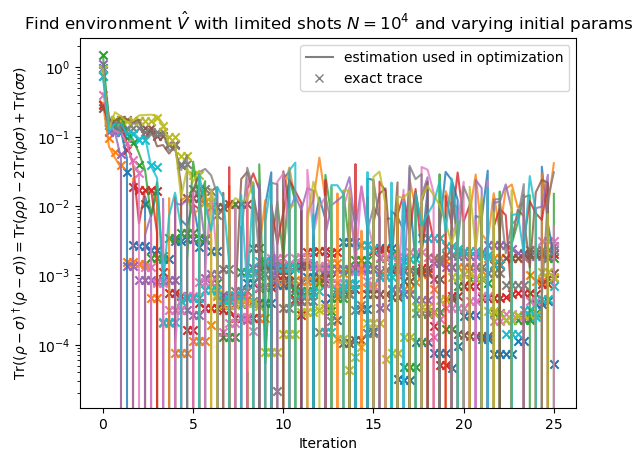

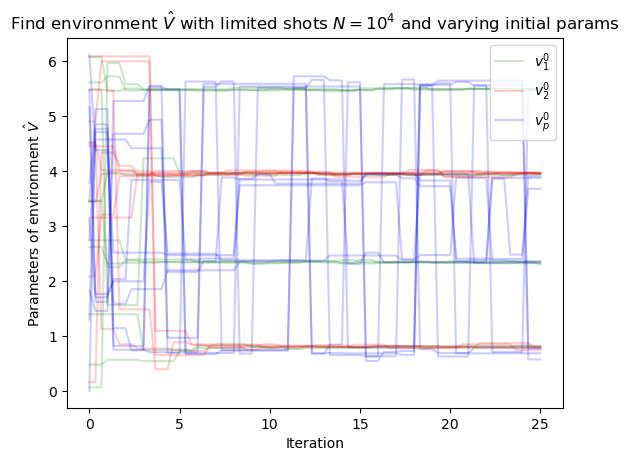

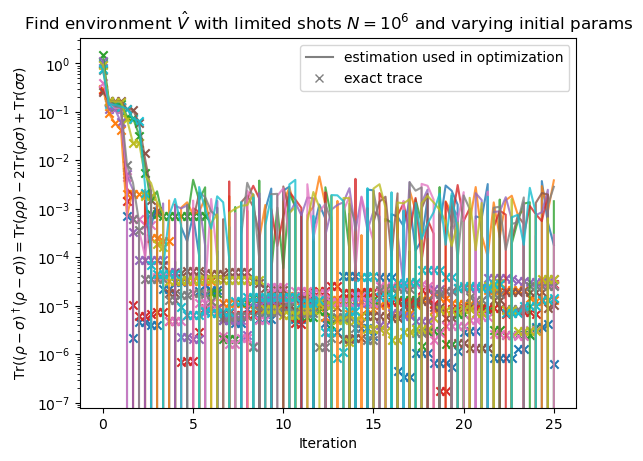

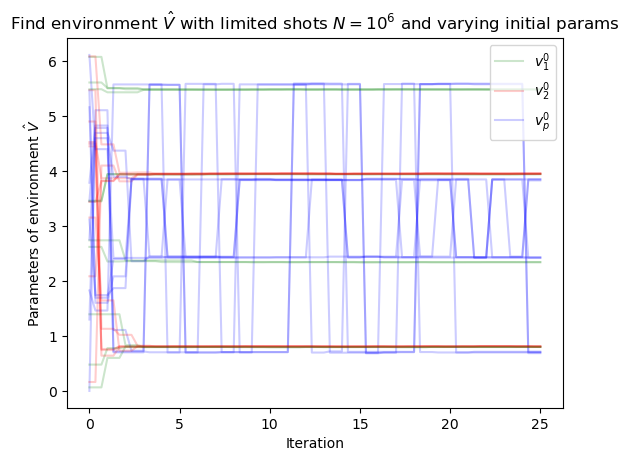

In [12]:
for desired_minimum in [0,-1]:
    # if desired minimum = -1 the optimization won't stop so easily and we can see, that the accuracy stays at shots^(-1/2)
    # (it might not always reach max iter because the optimization also stops if the parameters stay almost constant, which is very improbable given the noise
    for shots in [100, 10000, 1000000]:
        file_name = f"rotosolve-optimization_limited-shot-number:_{shots}__init-seed:_{{0}}" + ("" if desired_minimum==0 else "__max_iter")
        plot(file_name, f"Find environment $\\hat V$ with limited shots $N=10^{int(np.log10(shots))}$ and varying initial params", save=True, estimated=True)

In [70]:
for desired_minimum in [0,-1]:
    # if desired minimum = -1 the optimization won't stop so easily and we can see, that the accuracy stays at shots^(-1/2)
    # (it might not always reach max iter because the optimization also stops if the parameters stay almost constant, which is very improbable given the noise
    for shots in [100, 10000, 1000000]:
        file_name = f"rotosolve-optimization_limited-shot-number:_{shots}__simulation-seed:_{{0}}" + ("" if desired_minimum==0 else "__max_iter")
        
        for seed in range(10):
            set_estimator_options({"seed": Generator(PCG64(42+seed)), "shots": shots})
            result_file = result_dir + file_name.format(seed) + ".csv"
            V_init_params = get_init_params(4)
            V_params = find_environment_V(mps.U, mps.V, V_init_params.copy(), other_parameters = mps.U_params, desired_minimum=desired_minimum, quiet=True, tolerance=.0001, log_file=result_file, may_overwrite=True)
            print(V_params)
            # this should be 0 if the optimization worked well.
            estimate_trace_of_difference_classically(mps.U, mps.V, join_params(V_params, mps.U_params))

/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:567: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/interpolate/_polyint.py:574: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])
bad accuracy. new func value: [0.54946615], previous was [0.34521556]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.874953512031052, Parameter($v^0_2$): 4.046552551402729, Parameter($v^0_p$): 4.264385121916659}
{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.416189900874704}


bad accuracy. new func value: [0.43707512], previous was [0.02764632]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.59060753], previous was [0.29594947]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.72095872], previous was [0.2452564]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 4.548712398367997, Parameter($v^0_p$): 4.369217318262635}


bad accuracy. new func value: [0.2657414], previous was [0.00759393]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.33888337], previous was [0.2657414]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35207111], previous was [0.25941308]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.38621136], previous was [0.09213587]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.88001765740658, Parameter($v^0_2$): 4.991839136767819, Parameter($v^0_p$): 4.450119514956474}


bad accuracy. new func value: [0.30211775], previous was [0.17199818]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.3469155], previous was [0.30211775]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.57030264], previous was [0.17215164]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.742425783020499, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 2.3819358523169836}


bad accuracy. new func value: [0.25824531], previous was [0.09333514]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.39890908], previous was [0.06009525]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4858314564424013, Parameter($v^0_p$): 2.042182669548626}
{Parameter($v^0_1$): 5.82110903435856, Parameter($v^0_2$): 2.974558936050157, Parameter($v^0_p$): 2.031184534037587}


bad accuracy. new func value: [0.36033288], previous was [0.10504373]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.80234316366893, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.120558964883953}
{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 2.0536971465758738}
{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 2.0746253700210486}


bad accuracy. new func value: [0.0761439], previous was [0.07595717]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.497076413418334, Parameter($v^0_2$): 3.887900099089989, Parameter($v^0_p$): 2.3598996793510856}


bad accuracy. new func value: [0.10756277], previous was [0.09194204]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0384252], previous was [0.03666539]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.05567198], previous was [0.00923329]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.576344552270228, Parameter($v^0_2$): 3.884857008657341, Parameter($v^0_p$): 4.0938047572348655}


bad accuracy. new func value: [0.02082673], previous was [0.01439318]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02568732], previous was [0.02082673]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02443481], previous was [0.00989505]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.422264390210255, Parameter($v^0_2$): 4.039444648905008, Parameter($v^0_p$): 3.9079805426451037}


bad accuracy. new func value: [0.1416451], previous was [0.10454434]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.473552601669828, Parameter($v^0_2$): 3.923098116135365, Parameter($v^0_p$): 4.089547035666906}
{Parameter($v^0_1$): 5.45464048121795, Parameter($v^0_2$): 3.9515578315482474, Parameter($v^0_p$): 2.5151486285808553}


bad accuracy. new func value: [0.01151558], previous was [0.00669215]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.588591808867094, Parameter($v^0_2$): 3.8774101896737867, Parameter($v^0_p$): 2.379799080645433}
{Parameter($v^0_1$): 5.4635525134684855, Parameter($v^0_2$): 3.9127090637084847, Parameter($v^0_p$): 3.836520863475937}


bad accuracy. new func value: [0.12442763], previous was [0.11109127]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.05356173], previous was [0.05353012]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.09103646], previous was [0.05356173]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.04641092], previous was [0.03365809]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.04708624], previous was [0.03942837]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.532416244121519, Parameter($v^0_2$): 3.9024062651598554, Parameter($v^0_p$): 2.285562323354152}


bad accuracy. new func value: [0.19586466], previous was [0.07593418]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02532112], previous was [0.0113158]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.03350788], previous was [0.02532112]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.4476285001504525, Parameter($v^0_2$): 3.95847868711662, Parameter($v^0_p$): 2.4383785425486733}


bad accuracy. new func value: [0.14050758], previous was [0.08554546]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01550492], previous was [0.01369157]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.479759525595908, Parameter($v^0_2$): 3.9742305982946453, Parameter($v^0_p$): 2.2551122571514886}
{Parameter($v^0_1$): 5.490634442171403, Parameter($v^0_2$): 3.9360071711377125, Parameter($v^0_p$): 3.915950564062743}
{Parameter($v^0_1$): 5.482654231144721, Parameter($v^0_2$): 3.9446948937087463, Parameter($v^0_p$): 3.869681947360985}


bad accuracy. new func value: [0.00150838], previous was [0.0011051]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00227684], previous was [0.00150838]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00226224], previous was [0.00074717]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.4955603638033566, Parameter($v^0_2$): 3.944613279801933, Parameter($v^0_p$): 3.8513207993319805}


bad accuracy. new func value: [0.11486721], previous was [0.11452824]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.486435770439914, Parameter($v^0_2$): 3.9474271968605064, Parameter($v^0_p$): 2.435988383256605}
{Parameter($v^0_1$): 5.4879198012155666, Parameter($v^0_2$): 3.9394091842816907, Parameter($v^0_p$): 2.4195886489185177}
{Parameter($v^0_1$): 5.4883763526363385, Parameter($v^0_2$): 3.9276569621563686, Parameter($v^0_p$): 2.435099645372169}
{Parameter($v^0_1$): 5.487478201120677, Parameter($v^0_2$): 3.9261643429620086, Parameter($v^0_p$): 3.843483867722034}
{Parameter($v^0_1$): 5.487080999283418, Parameter($v^0_2$): 3.9307321196290594, Parameter($v^0_p$): 3.8516622553938955}


bad accuracy. new func value: [0.11965065], previous was [0.11159361]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.482483382699704, Parameter($v^0_2$): 3.9502906465302816, Parameter($v^0_p$): 2.440357357719022}


bad accuracy. new func value: [0.11505348], previous was [0.11256759]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


{Parameter($v^0_1$): 5.489533068055957, Parameter($v^0_2$): 3.949151978454386, Parameter($v^0_p$): 3.854935343645936}


bad accuracy. new func value: [0.54946615], previous was [0.34521556]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.30567069], previous was [-0.15573674]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.19903265], previous was [0.12973036]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.13632171], previous was [-0.19766038]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.13719482], previous was [0.13632171]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 5.63824416326973, Parameter($v^0_2$): 5.483621600708856, Parameter($v^0_p$): 1.7611363986963067}


bad accuracy. new func value: [0.01937386], previous was [-0.121873]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.05146361], previous was [0.01937386]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.42957934], previous was [-0.03339052]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.22203441], previous was [0.00561962]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.27467211], previous was [0.09446182]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 3.7714561246661837, Parameter($v^0_2$): 0.9145868166042259, Parameter($v^0_p$): 0.6583402699326846}


bad accuracy. new func value: [0.43707512], previous was [0.02764632]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.59060753], previous was [0.29594947]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.72095872], previous was [0.2452564]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35182559], previous was [-0.11182933]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.13857166], previous was [-0.21643153]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinuso

{Parameter($v^0_1$): 2.4135880500824682, Parameter($v^0_2$): 0.9026798754808611, Parameter($v^0_p$): 4.502435487811196}


bad accuracy. new func value: [0.2657414], previous was [0.00759393]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.33888337], previous was [0.2657414]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35207111], previous was [0.25941308]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.38621136], previous was [0.09213587]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.08711978], previous was [-0.00601273]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoid

{Parameter($v^0_1$): 1.2752543555611926, Parameter($v^0_2$): 0.6762795138012407, Parameter($v^0_p$): 4.04718752181353}


bad accuracy. new func value: [0.30211775], previous was [0.17199818]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.3469155], previous was [0.30211775]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.57030264], previous was [0.17215164]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.11490808], previous was [-0.02393536]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20187025], previous was [0.11490808]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 4.669588955101533, Parameter($v^0_2$): 4.0566108204822555, Parameter($v^0_p$): 2.076915431409722}


bad accuracy. new func value: [0.25824531], previous was [0.09333514]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.39890908], previous was [0.06009525]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.26811669], previous was [-0.24637816]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.0329785], previous was [-0.21967197]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.45595759], previous was [-0.1043094]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 5.270669260045939, Parameter($v^0_2$): 4.220649492718588, Parameter($v^0_p$): 2.039435632766606}


bad accuracy. new func value: [0.07176443], previous was [-0.00028452]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.09541727], previous was [-0.00529065]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.35182436], previous was [0.02109131]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.09894951], previous was [-0.134964]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.29972144], previous was [-0.09015349]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 3.0319843743294275, Parameter($v^0_2$): 2.1371756481861315, Parameter($v^0_p$): 4.804898907897156}


bad accuracy. new func value: [0.36033288], previous was [0.10504373]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.12192044], previous was [-0.08744017]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.37483445], previous was [0.12192044]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.52002634], previous was [-0.09624705]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.14556247], previous was [0.06398036]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 6.040943526081493, Parameter($v^0_2$): 3.7192414076874987, Parameter($v^0_p$): 4.353696334386231}


bad accuracy. new func value: [0.81407635], previous was [-0.26393731]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.27538397], previous was [-0.00331485]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.39133424], previous was [0.19550372]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.38496674], previous was [0.20968026]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.08514195], previous was [-0.13946661]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sin

{Parameter($v^0_1$): 5.681761251867529, Parameter($v^0_2$): 4.1800876341843285, Parameter($v^0_p$): 2.176440773635201}


bad accuracy. new func value: [0.33811522], previous was [-0.16343033]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.45587586], previous was [0.33811522]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.44706436], previous was [0.21584973]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.20070064], previous was [0.16853465]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.06261844], previous was [-0.08266955]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 1.9134488930764613, Parameter($v^0_2$): 4.271226051299906, Parameter($v^0_p$): 1.0252989450229881}


bad accuracy. new func value: [0.0761439], previous was [0.07595717]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00148037], previous was [-0.02107629]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00613891], previous was [-0.01939748]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00903668], previous was [0.00372839]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00361607], previous was [-0.01392346]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 5.481245880371112, Parameter($v^0_2$): 3.944794539599614, Parameter($v^0_p$): 3.8253725402385728}


bad accuracy. new func value: [0.10756277], previous was [0.09194204]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0384252], previous was [0.03666539]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.05567198], previous was [0.00923329]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02581715], previous was [-0.01153897]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0206795], previous was [-0.00351046]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.489892753041971, Parameter($v^0_2$): 3.9640439600164736, Parameter($v^0_p$): 3.837205842834084}


bad accuracy. new func value: [0.02082673], previous was [0.01439318]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02568732], previous was [0.02082673]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02443481], previous was [0.00989505]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00374742], previous was [-0.01452755]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00234506], previous was [-0.02393189]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinus

{Parameter($v^0_1$): 5.5054193517230345, Parameter($v^0_2$): 3.9434226671551533, Parameter($v^0_p$): 3.8720502448627014}


bad accuracy. new func value: [0.1416451], previous was [0.10454434]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01517594], previous was [-0.00124]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0138396], previous was [-0.0081945]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01128128], previous was [-0.01320374]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00617488], previous was [-0.01257802]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoid

{Parameter($v^0_1$): 5.4545744296987, Parameter($v^0_2$): 3.9638400989992792, Parameter($v^0_p$): 3.9185390969282317}


bad accuracy. new func value: [0.02184451], previous was [-0.00313065]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00383107], previous was [-0.00758082]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00740396], previous was [0.00383107]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01268813], previous was [-0.02033815]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01103863], previous was [-0.0169229]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 5.449877840132402, Parameter($v^0_2$): 3.9459113396661922, Parameter($v^0_p$): 2.3240524397635}


bad accuracy. new func value: [0.01151558], previous was [0.00669215]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01581792], previous was [-0.02254031]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.01159325], previous was [-0.02101719]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00060137], previous was [-0.01361284]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00803155], previous was [-0.02731201]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 5.477588788605458, Parameter($v^0_2$): 3.931615691748415, Parameter($v^0_p$): 2.361991890107451}


bad accuracy. new func value: [0.00434923], previous was [-0.0024146]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00908622], previous was [-0.01293568]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [8.91196343e-05], previous was [-0.00903975]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0007752], previous was [8.91196343e-05]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01540192], previous was [-0.02321576]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doub

{Parameter($v^0_1$): 5.492571471192932, Parameter($v^0_2$): 3.9705082341509663, Parameter($v^0_p$): 3.676228133476435}


bad accuracy. new func value: [0.12442763], previous was [0.11109127]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.05356173], previous was [0.05353012]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.09103646], previous was [0.05356173]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.04641092], previous was [0.03365809]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.04708624], previous was [0.03942837]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.4800739878129265, Parameter($v^0_2$): 3.91436901257552, Parameter($v^0_p$): 3.8760077222309763}


bad accuracy. new func value: [0.19586466], previous was [0.07593418]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02532112], previous was [0.0113158]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.03350788], previous was [0.02532112]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.01042697], previous was [-0.01485419]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00761173], previous was [-0.03231841]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 5.491970606386093, Parameter($v^0_2$): 3.9766610376353366, Parameter($v^0_p$): 2.3366553150875324}


bad accuracy. new func value: [0.14050758], previous was [0.08554546]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01550492], previous was [0.01369157]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00085474], previous was [-0.0045898]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.01327128], previous was [0.00085474]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.02306726], previous was [0.01327128]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.4997777902492695, Parameter($v^0_2$): 3.9637732545161453, Parameter($v^0_p$): 3.8991482910907242}


bad accuracy. new func value: [0.00137967], previous was [-0.00124909]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00199775], previous was [0.00119976]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [5.49442494e-05], previous was [-0.00216674]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00042519], previous was [-0.00209558]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.0007139], previous was [0.00020124]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly s

{Parameter($v^0_1$): 5.483480447883391, Parameter($v^0_2$): 3.950067317165739, Parameter($v^0_p$): 3.8419049770632405}


bad accuracy. new func value: [0.00048613], previous was [-0.00350365]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00139508], previous was [-0.00214998]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00130769], previous was [-0.00096323]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.001052], previous was [-0.00045735]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00139701], previous was [0.001052]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoi

{Parameter($v^0_1$): 5.48439574149409, Parameter($v^0_2$): 3.95190913573403, Parameter($v^0_p$): 3.86840363389398}


bad accuracy. new func value: [0.00150838], previous was [0.0011051]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00227684], previous was [0.00150838]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00226224], previous was [0.00074717]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [5.37972819e-05], previous was [-0.00167699]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-2.85979704e-05], previous was [-0.00260935]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doub

{Parameter($v^0_1$): 5.485860413317761, Parameter($v^0_2$): 3.9498518431019347, Parameter($v^0_p$): 3.8476834237156847}


bad accuracy. new func value: [0.11486721], previous was [0.11452824]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00029862], previous was [-0.00107641]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00124673], previous was [-0.00090597]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00104581], previous was [-0.00137338]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00068747], previous was [-0.0014037]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 5.481021013103534, Parameter($v^0_2$): 3.9517845614921345, Parameter($v^0_p$): 3.854777050289396}


bad accuracy. new func value: [0.00040824], previous was [-0.00081277]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00067498], previous was [0.00040824]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00129778], previous was [-0.00217697]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00116654], previous was [-0.00186986]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00117962], previous was [0.00102208]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinu

{Parameter($v^0_1$): 5.481131763824351, Parameter($v^0_2$): 3.950141158646615, Parameter($v^0_p$): 2.4237579349239367}


bad accuracy. new func value: [0.00084065], previous was [-0.00271737]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00132311], previous was [-0.00205912]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00028249], previous was [-0.00168525]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00057054], previous was [-0.0027629]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00207837], previous was [0.00057054]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly si

{Parameter($v^0_1$): 5.483134273676492, Parameter($v^0_2$): 3.949320830848637, Parameter($v^0_p$): 2.431032519385853}


bad accuracy. new func value: [0.00041401], previous was [-0.00016832]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00101646], previous was [-0.00116748]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-7.13695929e-05], previous was [-0.00092996]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [1.52052574e-05], previous was [-7.13695929e-05]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00148895], previous was [-0.00236474]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it

{Parameter($v^0_1$): 5.484583220338167, Parameter($v^0_2$): 3.9519505631444316, Parameter($v^0_p$): 3.829304962845515}


bad accuracy. new func value: [0.00237496], previous was [-0.00139032]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00017494], previous was [-0.00080799]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00020433], previous was [-0.0007856]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00122716], previous was [-0.00054031]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00218056], previous was [-0.00238321]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly s

{Parameter($v^0_1$): 5.483364987520691, Parameter($v^0_2$): 3.9467142777996447, Parameter($v^0_p$): 3.847871494088073}


bad accuracy. new func value: [0.11965065], previous was [0.11159361]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00104348], previous was [-0.00157236]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00088056], previous was [-0.00327259]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00041922], previous was [-0.00088056]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00067652], previous was [-0.00041922]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly 

{Parameter($v^0_1$): 5.48432265969252, Parameter($v^0_2$): 3.9533457853493665, Parameter($v^0_p$): 2.4232088967557925}


bad accuracy. new func value: [0.11505348], previous was [0.11256759]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [5.3131736e-05], previous was [-0.00082734]. The old $v^0_p$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00070284], previous was [5.3131736e-05]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [0.00156802], previous was [0.00070284]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.
bad accuracy. new func value: [-0.00072801], previous was [-0.00109451]. The old $v^0_1$ was possibly better.
improve your cost function accuracy, check that it is doubl

{Parameter($v^0_1$): 5.485212039876821, Parameter($v^0_2$): 3.951810174224913, Parameter($v^0_p$): 3.851235956122636}


reached max iter: 25.
========warning: desired_minimum: -1 not reached, fun is at -0.0019225526121104952.


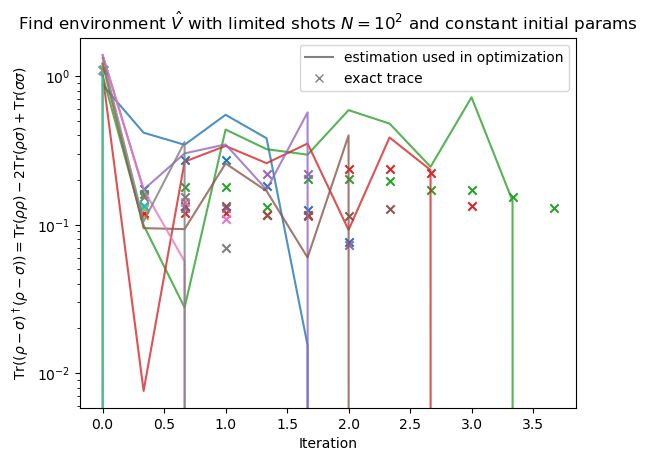

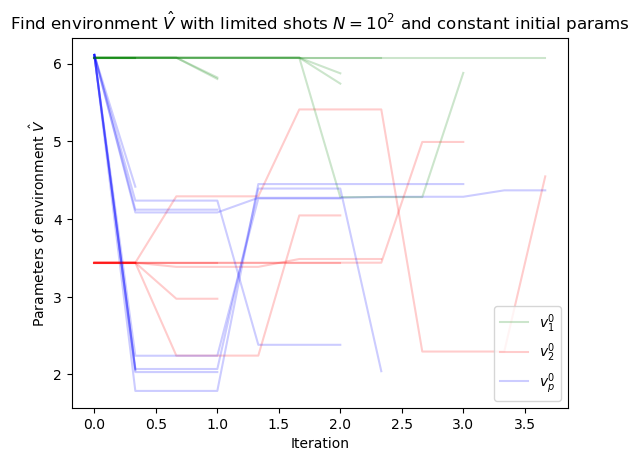

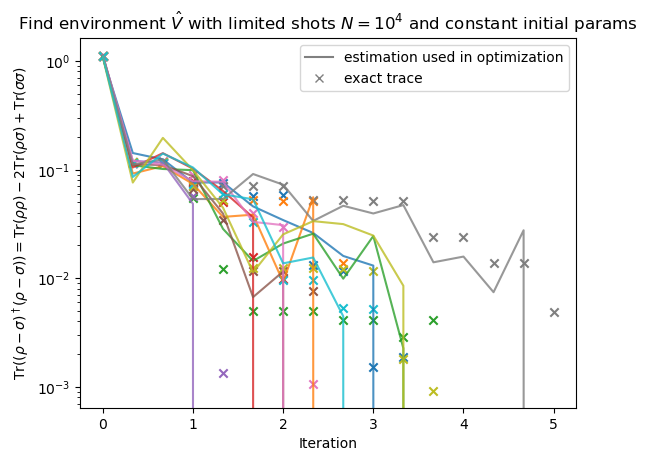

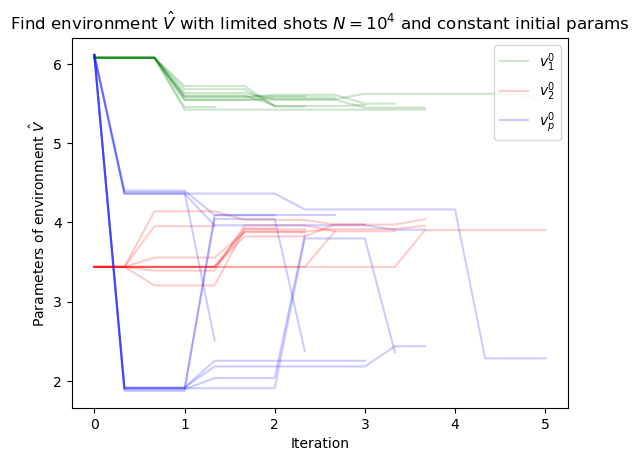

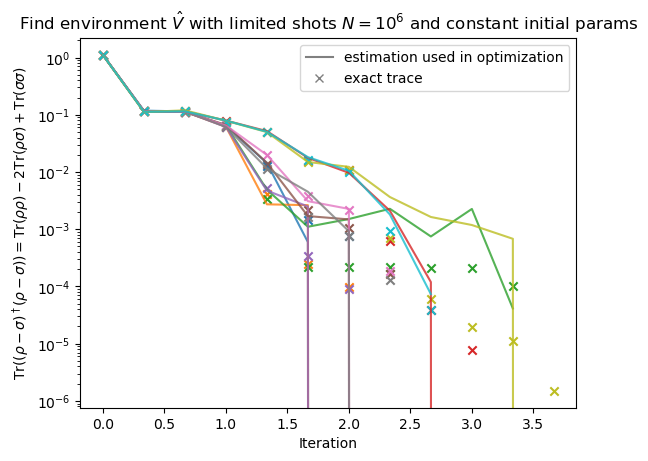

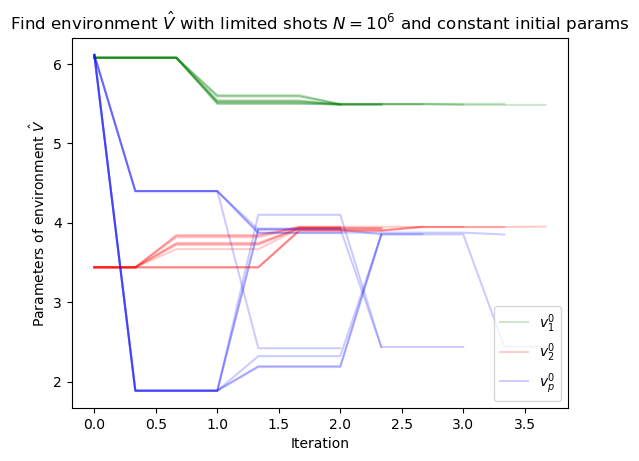

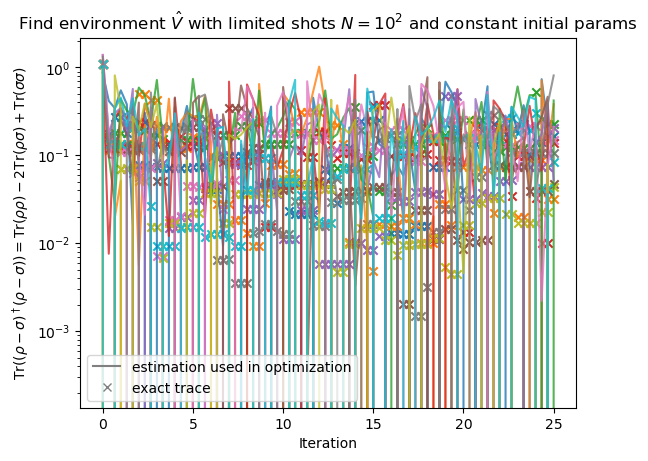

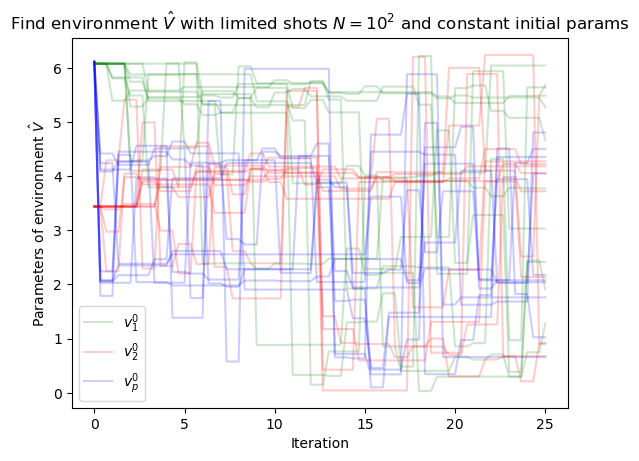

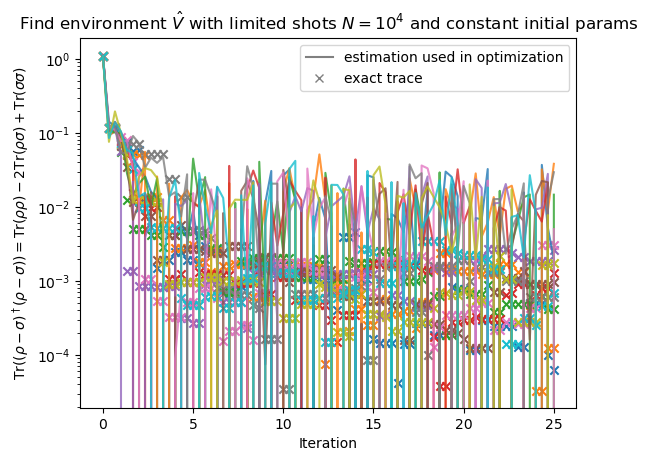

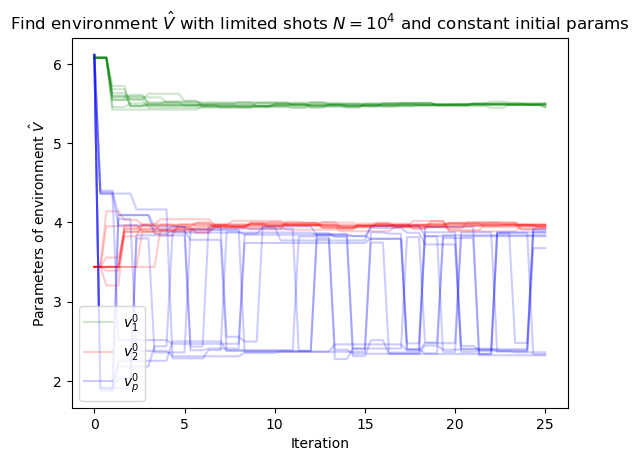

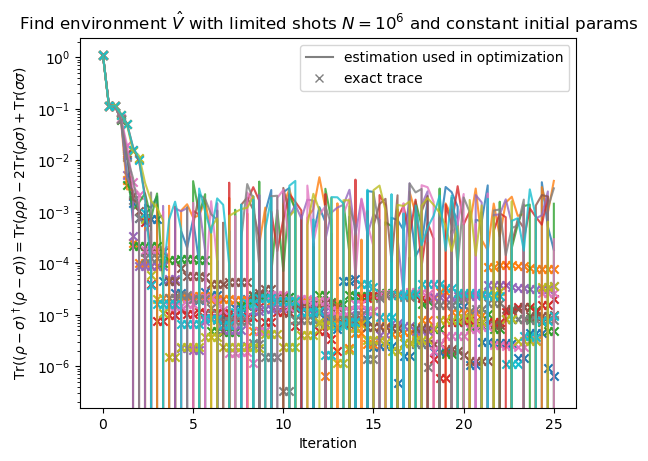

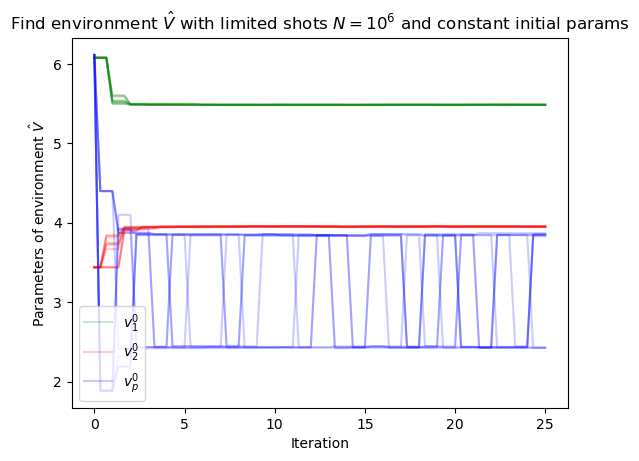

In [13]:
for desired_minimum in [0,-1]:
    # if desired minimum = -1 the optimization won't stop so easily and we can see, that the accuracy stays at shots^(-1/2)
    # (it might not always reach max iter because the optimization also stops if the parameters stay almost constant, which is very improbable given the noise
    for shots in [100, 10000, 1000000]:
        file_name = f"rotosolve-optimization_limited-shot-number:_{shots}__simulation-seed:_{{0}}" + ("" if desired_minimum==0 else "__max_iter")
        plot(file_name, f"Find environment $\\hat V$ with limited shots $N=10^{int(np.log10(shots))}$ and constant initial params", save=True, estimated=True)

# using ibmq_qasm_simulator

this is a free way to test circuits before running them on Quantum Hardware.

In [9]:
V_init_params = get_init_params(4)
print(V_init_params)

{Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 6.111556079054741}


In [15]:
service, provider = init_IBM_connection()
service, provider

(<QiskitRuntimeService>, <IBMProvider>)

In [16]:
from qiskit_ibm_runtime import Sampler, Estimator, Session, Options

In [17]:
options = Options(optimization_level=3, resilience_level=0, execution={"shots":10000})

In [18]:
settings["log all jobs"] = True


In [19]:
backend = "ibmq_qasm_simulator"
settings["log all jobs"] = True
with Session(service=service, backend=backend) as session:
    print("started")
    result_file = result_dir+f"rotosolve_optimization_{backend} {time.ctime()}.csv"
    set_estimator(Estimator, session=session, options=options)
    result = find_environment_V(mps.U, mps.V, V_init_params.copy(), other_parameters = mps.U_params, quiet=False, desired_minimum=0, tolerance=.01, log_file=result_file)
    session.close()
print(result)

started
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 6.111556079054741}
sinusoidal args: (0.2728762118853226, 1.6196981806863031, 0.36861200468785604, 1.5368788286601345)
new $v^0_p$: 4.351377893404375
current value: [0.1046]
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.351377893404375}
sinusoidal args: (0.012030015372355348, 2.145107567749137, 0.06831412738226263, 1.1339923010475783)


bad accuracy. new func value: [0.1132], previous was [0.1046]. The old $v^0_2$ was possibly better.
improve your cost function accuracy, check that it is doubly sinusoidal or try larger tollerance.


current value: [0.1132]
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.351377893404375}
sinusoidal args: (0.058556424645289123, -0.1327404485622205, 0.15130978157409397, -0.7054004768650494)
new $v^0_1$: 5.506681937034921
current value: [0.0956]
current params: {Parameter($v^0_1$): 5.506681937034921, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.351377893404375}
sinusoidal args: (0.167501941202755, 1.5957005098463493, 0.4142207261835167, 1.5466522630298691)
new $v^0_p$: 4.055413271377899
current value: [0.0586]
current params: {Parameter($v^0_1$): 5.506681937034921, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.055413271377899}
sinusoidal args: (0.05796136944942389, 2.194454384039224, 0.3658067385929351, 1.0560242521968672)
new $v^0_2$: 3.9194052347177455
current value: [-0.0214]
{Parameter($v^0_1$): 5.506681937034921, Parameter($v^0_2$): 3.9194052347177455, Parameter($v^0_p$): 4.0554

In [20]:
session.close()

In [21]:
result = np.genfromtxt(result_file, skip_header=True, delimiter=",")

Text(0.5, 1.0, 'optimization of env using ibmq_qasm_simulator')

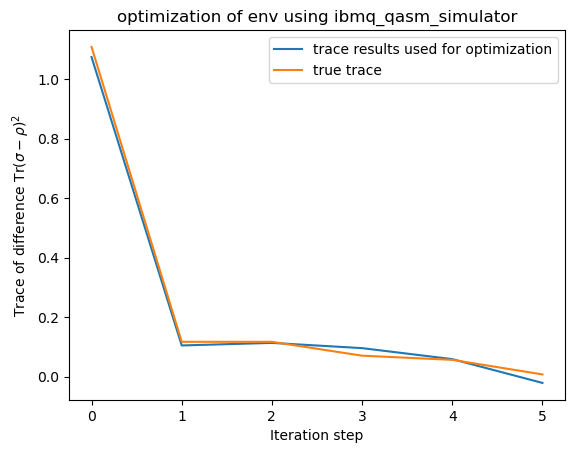

In [22]:
plt.plot(result[:,0], label="trace results used for optimization")
classical_trace_diff = [estimate_trace_of_difference_classically(mps.U, mps.V, join_params(mps.U_params, dict(zip(mps.V_param_n, result[i,1:]))))
                        for i in range(0,len(result))]
plt.plot(classical_trace_diff, label="true trace")
plt.legend()
plt.ylabel("Trace of difference $\\mathrm{Tr}(σ-ρ)^2$")
plt.xlabel("Iteration step")
plt.title(f"optimization of env using {backend}")

Text(0.5, 0, 'Iteration step')

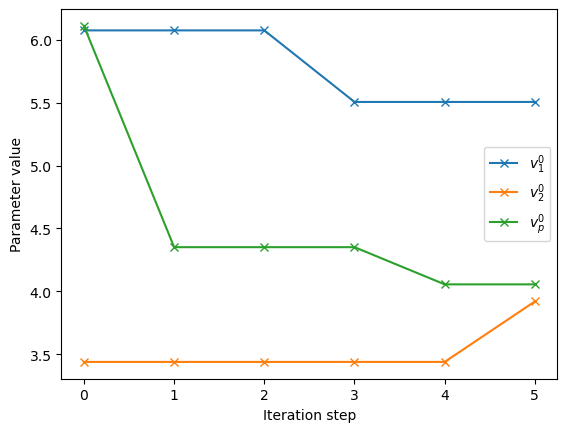

In [23]:
plt.plot(result[:,1:], marker="x", label=mps.V_param_n)
plt.legend()
plt.ylabel("Parameter value")
plt.xlabel("Iteration step")

# on a real quantum computer

In [24]:
options = Options(optimization_level=3, resilience_level=2, execution={"shots":10000})

In [31]:
backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= 5
                                       and not x.configuration().simulator 
                                       and x.status().operational==True)
backend = least_busy(backends)
print(backends, "\n\nleast busy:", backend)

[<IBMBackend('ibm_lagos')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibm_brisbane')>] 

least busy: <IBMBackend('ibm_lagos')>


In [32]:
backend = backend.name
settings["log all jobs"] = True
with Session(service=service, backend=backend) as session:
    print("started")
    result_file = result_dir+f"rotosolve_optimization_{backend} {time.ctime()}.csv"
    set_estimator(Estimator, session=session, options=options)
    result = find_environment_V(mps.U, mps.V, V_init_params.copy(), other_parameters = mps.U_params, quiet=False, desired_minimum=0, tolerance=.01, log_file=result_file)
    session.close()
print(result)

started
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 6.111556079054741}
sinusoidal args: (0.3478019609697717, 1.295840048722801, 0.12877577223177059, -1.1102453103158338)
new $v^0_p$: 4.922631716839602
current value: [0.25145]
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 3.4383616276357367, Parameter($v^0_p$): 4.922631716839602}
sinusoidal args: (0.09400510849531689, -2.4826396212924204, 0.27223998094001944, -0.37738007282454294)
new $v^0_2$: 4.332317446072633
current value: [0.13258333]
current params: {Parameter($v^0_1$): 6.076027676094974, Parameter($v^0_2$): 4.332317446072633, Parameter($v^0_p$): 4.922631716839602}
sinusoidal args: (0.07999082399553659, 1.2968640653148673, 0.41954087885184416, 1.8290764471683236)


IBMRuntimeError: 'Failed to run program: \'403 Client Error: Forbidden for url: https://api.quantum-computing.ibm.com/runtime/jobs. {"errors":[{"message":"Job create exceeds open plan job usage limits","code":4317,"solution":"Please wait until the beginning of next month to submit more jobs when your quota will reset.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [33]:
session.close()

In [28]:
result = np.genfromtxt(result_file, skip_header=True, delimiter=",")

Text(0.5, 1.0, 'optimization of env using ibm_perth')

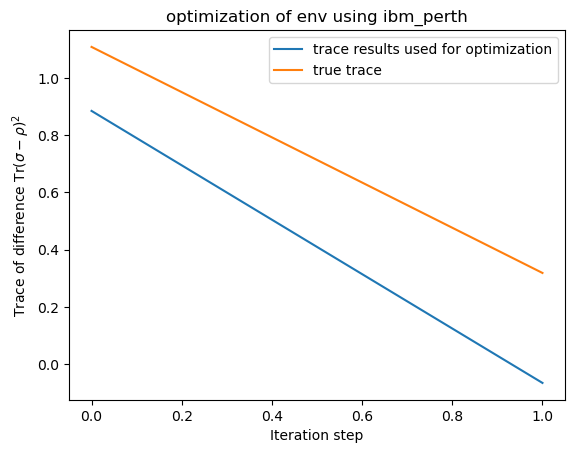

In [29]:
plt.plot(result[:,0], label="trace results used for optimization")
classical_trace_diff = [estimate_trace_of_difference_classically(mps.U, mps.V, join_params(mps.U_params, dict(zip(mps.V_param_n, result[i,1:]))))
                        for i in range(0,len(result))]
plt.plot(classical_trace_diff, label="true trace")
plt.legend()
plt.ylabel("Trace of difference $\\mathrm{Tr}(σ-ρ)^2$")
plt.xlabel("Iteration step")
plt.title(f"optimization of env using {backend}")

Text(0.5, 0, 'Iteration step')

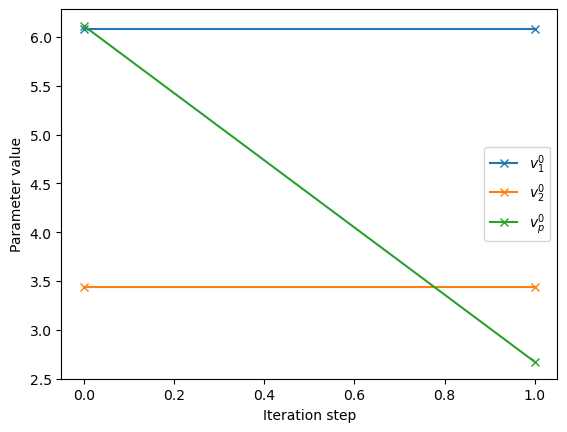

In [30]:
plt.plot(result[:,1:], marker="x", label=mps.V_param_n)
plt.legend()
plt.ylabel("Parameter value")
plt.xlabel("Iteration step")

In [34]:
result = np.genfromtxt(result_file, skip_header=True, delimiter=",")

Text(0.5, 1.0, 'optimization of env using ibm_lagos')

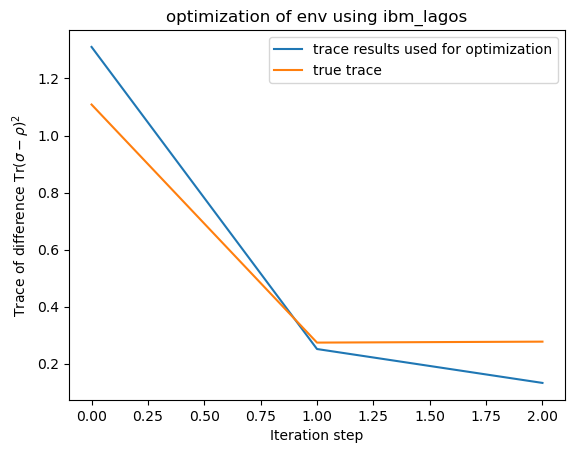

In [35]:
plt.plot(result[:,0], label="trace results used for optimization")
classical_trace_diff = [estimate_trace_of_difference_classically(mps.U, mps.V, join_params(mps.U_params, dict(zip(mps.V_param_n, result[i,1:]))))
                        for i in range(0,len(result))]
plt.plot(classical_trace_diff, label="true trace")
plt.legend()
plt.ylabel("Trace of difference $\\mathrm{Tr}(σ-ρ)^2$")
plt.xlabel("Iteration step")
plt.title(f"optimization of env using {backend}")

Text(0.5, 0, 'Iteration step')

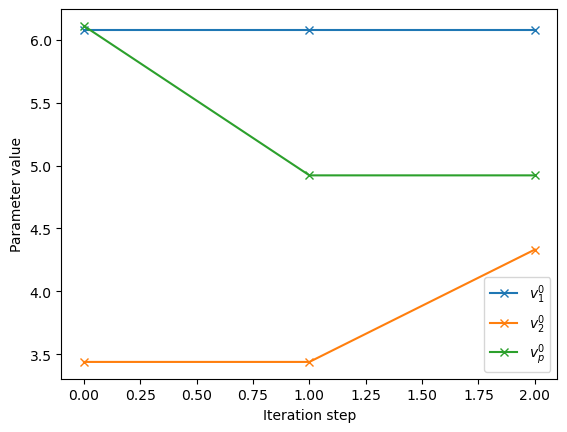

In [36]:
plt.plot(result[:,1:], marker="x", label=mps.V_param_n)
plt.legend()
plt.ylabel("Parameter value")
plt.xlabel("Iteration step")

In [16]:
# plotting QC results

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


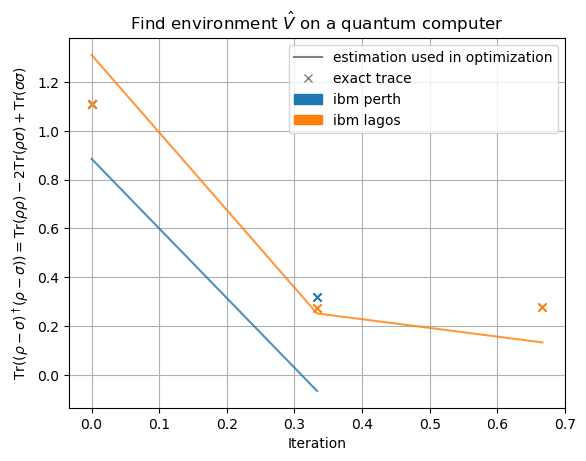

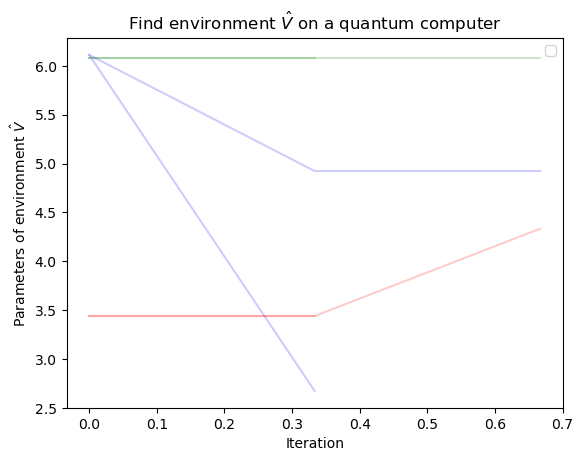

In [25]:
import matplotlib.patches as mpatches

fig_trace, ax_trace = plt.subplots()
fig_V_params, ax_V_params = plt.subplots()
for i, result_file in enumerate(["rotosolve_optimization_ibm_perth Thu Oct 12 17:44:59 2023.csv", "rotosolve_optimization_ibm_lagos Thu Oct 12 20:51:35 2023.csv"]):
    result = np.genfromtxt(result_dir + result_file, skip_header=True, delimiter=",")
    x = np.arange(result.shape[0])/len(mps.V_param_n)
    ax_trace.plot(x, result[:,0], alpha=.8, color=cmap(i))
    
    params_list = [join_params(dict(zip(mps.V_param_n, params)), mps.U_params) for params in result[:,1:]]
    ax_trace.scatter(x, estimate_trace_of_difference(mps.U, mps.V, params_list), color=cmap(i), marker="x")
    #print(result[:,0])
    for i in range(1,4):
        ax_V_params.plot(x, result[:,i], color=colors[i-1], alpha = .2, label=str(mps.V_param_n[i-1]) if i==0 else None)

title = "Find environment $\\hat V$ on a quantum computer"
ax_V_params.legend()
ax_V_params.set_title(f"{title}")
ax_V_params.set_ylabel("Parameters of environment $\\hat V$")
ax_V_params.set_xlabel("Iteration")
ax_trace.set_title(f"{title}")
ax_trace.set_ylabel("$\\mathrm{Tr}((ρ-σ)^\\dagger (ρ-σ)) = \\mathrm{Tr}(ρρ)-2\\mathrm{Tr}(ρσ)+\\mathrm{Tr}(σσ)$")
ax_trace.set_xlabel("Iteration")

# Create custom legend entries
data_line = mlines.Line2D([], [], color='gray', label='estimation used in optimization')
marker = mlines.Line2D([], [], color='gray', marker='x', linestyle='None', label='exact trace')
perth_patch = mpatches.Patch(color=cmap(0), label='ibm perth')
lagos_patch = mpatches.Patch(color=cmap(1), label='ibm lagos')

# Add a legend with the custom legend entries
ax_trace.legend(handles=[data_line, marker, perth_patch, lagos_patch])
ax_trace.grid()


file_name = "rotosolve_optimization_ibm_quantum-computers"
fig_trace.savefig(result_dir + file_name + "_trace.pdf")
fig_V_params.savefig(result_dir + file_name + "_V_params.pdf")